In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()  # This helps make our plots look nicer

# These make our figures bigger
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.dpi'] = 100

# Hypothesis Testing

*You may find it helpful to review [Chapter 11](https://inferentialthinking.com/chapters/11/Testing_Hypotheses.html) and [Chapter 12](https://inferentialthinking.com/chapters/12/Comparing_Two_Samples.html) of the Data 8 textbook, which cover the basics of hypothesis testing.*

Hypothesis testing is a specific kind of binary decision-making problem. Although the null hypothesis statistical test (NHST) framework has been criticized in recent years, it still provides a useful framework for making decisions from data. We'll explore these criticisms later, but to start, here's a quick refresher on how the process works:

1. Determine the viewpoint that you want to test, and decide on:
   * Null hypothesis: a chance model under which you can simulate data (or analytically compute the distribution of your data)
   * Alternative hypothesis: viewpoint from the question
   * Test statistic: quantity computed from your data to help you decide between the two hypotheses (in this book, we'll always use the convention that larger values of the test statistic should favor the alternative hypothesis).
2. Compute the value of the test statistic on your data
3. Compute the distribution of the test statistic under the null distribution, either by simulation or analytically
4. Compute a p-value: this is the probability, if the null hypothesis is true, that the test statistic is equal to or larger than the observed value.
5. Compare that p-value to some threshold: if the p-value is smaller, our test statistic was very unlikely under the null, so our data support the alternative hypothesis. If the p-value is larger, then the data support the null hypothesis.

### Hypothesis testing and binary decision-making

We can see that hypothesis testing (as we've defined it above) is a binary decision-making problem: we must decide between the null and alternative hypotheses, and we're assuming that there is some underlying true hypothesis. In this case, **reality** corresponds to which hypothesis is actually true, and we make our **decision** based on the p-values. 

In order to translate the p-values into binary decisions, we'll have to decide on some threshold(s) for doing so: we'll spend the rest of this chapter analyzing different ways to pick this threshold (or thresholds), and what assumptions are encoded in each one.

Here are some important notes about conventions and vocabulary:
* By convention, we'll always define the null hypothesis as 0, and the alternative hypothesis as 1.
* We'll use the following terms interchangeably (in other words, they all mean the same thing):
  * "reject the null hypothesis"
  * "make a discovery"
  * "make a decision of 1"

### Example: p-value thresholds for e-commerce website optimization

Suppose we are exploring ways to make our e-commerce site more appealing to customers. We make 100 different changes to the website (different colors, fonts, page layouts, etc.), and for each one, we use an A/B test to see whether customers are more likely to make a purchase. We define the following null and alternative hypotheses:

* Null hypothesis: the change to the website has no effect on whether or not customers make a purchase.
* Alternative hypothesis: the change increases the chance that customers will make a purchase.

For each change, we randomly assign half the users of our website to the old version, and half to the new version: because this is a randomized experiment, we can determine whether our change *causes* customers to purchase products more. Our test statistic is the difference between the percentage of people who made a purchase in the treatment group (new version of website) and the same percentage in the control group (old version of website). We simulate the test statistic under the null hypothesis, and obtain a p-value for each test. These p-values are in the following dataframe:

In [2]:
p_values = pd.read_csv('p_values.csv')
p_values[['pvalue']].head(3)

,pvalue
0,0.040131
1,0.000436
2,0.251129


We can visualize the distribution of them using a strip plot, which gives us a scatterplot-like view. Each point represents one test, the x-axis represents the p-value, and the y-axis doesn't have any meaning (it just helps spread out the points so they're easier to see):

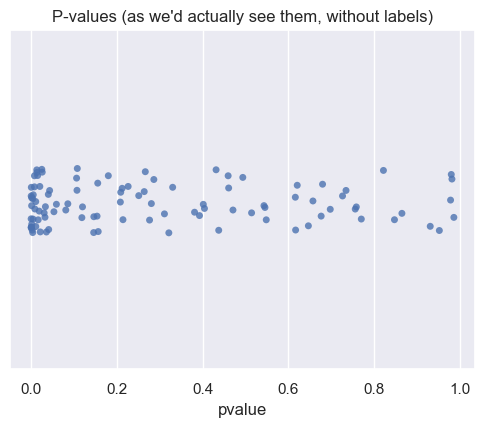

In [3]:
sns.stripplot(
    data=p_values, x='pvalue',
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.title("P-values (as we'd actually see them, without labels)");

Normally, we wouldn't know for certain whether or not each change actually affects customer behavior. Instead, we must decide from the p-values. In particular, our job is to decide, based on the p-values, for which tests the data favor the null hypothesis, and for which tests the data favor the alternative hypothesis. From the definition of the p-value, we know that smaller p-values should favor the alternative hypothesis, while larger p-values should favor the null hypothesis.

What if we did magically know the true effect of each change? In this case, we could use that known truth to analyze our decision-making process and evaluate how well we do. 

This is an approach we'll use many times throughout this book: when creating, designing, and evaluating our algorithms, we'll suppose that we know the "true" values of reality, so that we can provide a quantitative analysis. Then, when we go apply those algorithms in the real world (where we don't know reality), we can be confident in how well we're doing.

The column `is_alternative` contains the known true effects for each of these 100 A/B tests:

In [4]:
p_values.head(3)

,pvalue,is_alternative
0,0.040131,0
1,0.000436,1
2,0.251129,0


We can visualize the p-values, grouped by whether or not the website change actually affected customers' purchase behavior (i.e., reality):

(-0.049319194537530316, 1.035869189459966, 1.5, -0.5)


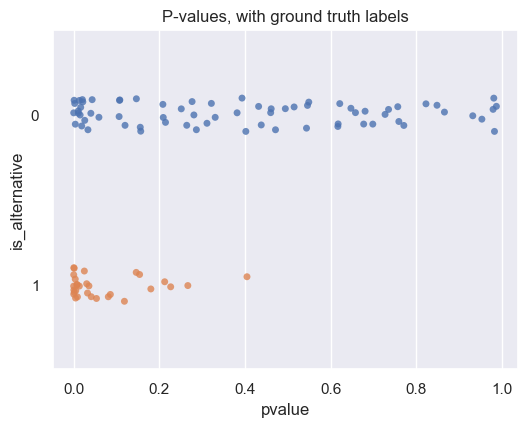

In [8]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.title('P-values, with ground truth labels');
print(plt.axis())

We can now see that any particular threshold we choose will lead us to make some correct and some incorrect decisions. For example, suppose we use a p-value threshold of 0.1:

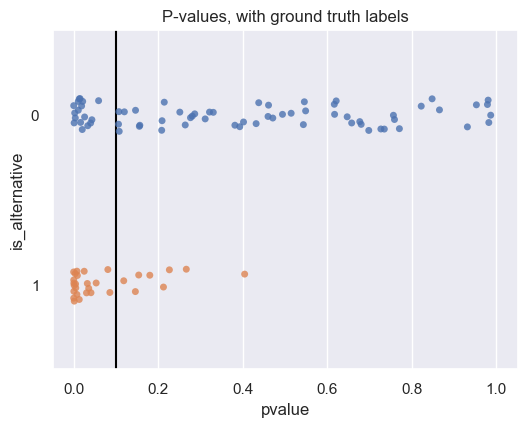

In [10]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.vlines(0.1, -0.5, 1.5, color='black')
plt.axis([-0.05, 1.05, 1.5, -0.5])
plt.title('P-values, with ground truth labels');

For p-values smaller than our threshold (to the right of the line), our decision is 1. So:
* For all the orange (bottom) points to the left of the line, we make a correct decision: in this case, reality and our decision are both 1 (alternative), so these are *true positives*. 
* For all the orange (bottom) points to the right of the line, we make an incorrect decision: in this case, reality is 1 (alternative), but our decision is 0 (null). So, these are *false negatives*.
* For all the blue (top) points to the left of the line, we make an incorrect decision: in this case, reality is 0 (null), but our decision is 1 (alternative). So, these are *false positives*.
* For all the blue (top) points to the right of the line, we make a correct decision: in this case, reality and our decision are both 0 (null), so these are *true negatives*. 

Our goal should be to make as many true negatives and true positives as possible, while making as few false positives and false negatives as possible. But we can see from the graph that there is a tradeoff: as we make fewer false positives, we must necessarily make more false negatives. For example, suppose we wanted to have no false negatives at all. That means we want all the p-values from tests where the alternative is true to be below our threshold (all orange points to the left of the line).Let's see what happens if we choose such a threshold of 0.42:

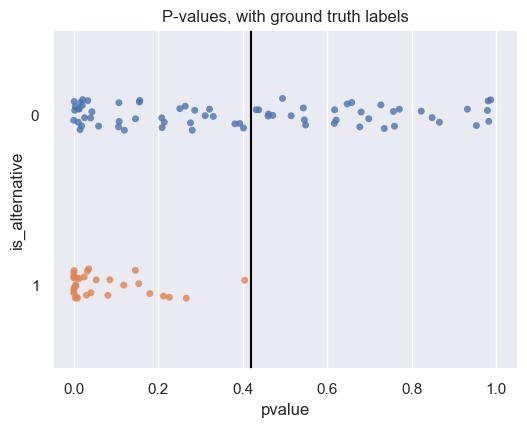

In [12]:
sns.stripplot(
    data=p_values, x='pvalue', y='is_alternative', 
    alpha = 0.8, order = [0, 1], orient = "h",
)
plt.vlines(0.42, -0.5, 1.5, color='black')
plt.axis([-0.05, 1.05, 1.5, -0.5])
plt.title('P-values, with ground truth labels');

Even though we've dropped our false negative rate dramatically, we've unfortunately increased our false positive rate: there are now many more tests where the null is true but the p-value is below our threshold (blue points to the left of the line).

### From p-values to decisions

We've seen above that in order to make a binary decision from a single p-value, we must use some threshold. We'll see several different ways to choose such a threshold:

* Classical null hypothesis significance testing (NHST): here, we choose a threshold based on our desired false positive rate. For example, the traditional (arbitrary) threshold of 0.05 corresponds to a 5% chance of making a false positive with each hypothesis test we conduct. In this setting, our null hypothesis will usually be clearly specified, but we usually use "vague" alternative hypotheses such as 'there is no difference between the two groups'. This means that we can precisely analyze what happens when the null is true ($R=0$), and reason about the false positive rate and true negative rate. However, because we don't have a precisely defined alternative hypothesis, we typically don't reason about the true positive rate and false negative rate (i.e., the rates corresponding to $R=1$).
* In the Neyman-Pearson framework, we choose a more precise alternative hypothesis, and reason about the true positive rate. We'll discuss this briefly in the next section.
* When making multiple tests, we'll need to choose thresholds that take into account error rates involving all the tests we conduct. We'll examine these error rates and why they're important in the next section.